## Imports

In [29]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
from multiprocessing import Pool

import modeling
import helpers
import plotting
import scienceplots
plt.style.use(['science','no-latex'])
# plt.style.use(['science','ieee','no-latex'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [30]:
with open('data.pkl', 'rb') as file:
    data_dict = pickle.load(file)
    all_data = data_dict['data']
    meta_data = data_dict['meta_data']

## Fit models

In [31]:
subject_inds = (meta_data['Condition'] == 'V1-V1') & (meta_data['Cluster'] == 0)
this_data = helpers.slice_data(all_data, meta_data, 'V1-V1', exp=[1,2], cluster=0)
num_subject = all_data['tr'].shape[0]

alpha_bounds = [1e-6, 1]
beta_bounds = [1e-6, 20]
concentration_bounds = [-2, 1]
epsilon_bounds = [0, 1]
bounds = [alpha_bounds, beta_bounds, beta_bounds, concentration_bounds, epsilon_bounds] 
param_names = ['alpha_2', 'beta_2', 'beta_policies', 'concentration_2', 'v_repeat']

### Backward structured model without meta-learning (fitted to Blocks 1-6)

In [32]:
this_model = 'option_model'
structure = 'backward'
meta_learning = False

best_llh_all = np.zeros(num_subject)
best_params_all = np.zeros((num_subject, len(param_names)))

D = helpers.get_model_fit_data(this_data, num_block=6)

if __name__ == "__main__":
    inputs = []
       
    for i in range(num_subject):
        if subject_inds[i]:
            inputs.append((this_model, D[D[:,0]==i,:], structure, i, bounds, meta_learning))

    with Pool() as p:
        results = p.map(modeling.parallel_worker, inputs)

    for i, best_params, best_llh in results:
        best_params_all[i, :], best_llh_all[i] = best_params, best_llh

np.save('fitting_results/'+structure+'_no_meta_params.npy', best_params_all)
np.save('fitting_results/'+structure+'_no_meta_llh.npy', best_llh_all)

### Backward structured model (fitted to Blocks 1-6)

In [33]:
this_model = 'option_model'
structure = 'backward'
meta_learning = True

best_llh_all = np.zeros(num_subject)
best_params_all = np.zeros((num_subject, len(param_names)))

D = helpers.get_model_fit_data(this_data, num_block=6)

if __name__ == "__main__":
    inputs = []
       
    for i in range(num_subject):
        if subject_inds[i]:
            inputs.append((this_model, D[D[:,0]==i,:], structure, i, bounds, meta_learning))

    with Pool() as p:
        results = p.map(modeling.parallel_worker, inputs)

    for i, best_params, best_llh in results:
        best_params_all[i, :], best_llh_all[i] = best_params, best_llh

np.save('fitting_results/'+structure+'_blocks1-6_params.npy', best_params_all)
np.save('fitting_results/'+structure+'_blocks1-6_llh.npy', best_llh_all)

## Plot fit

### Set up

In [34]:
# Load fitted parameters
best_params_all_backward_no_meta = np.load('fitting_results/backward_no_meta_params.npy')
best_params_all_backward_first6 = np.load('fitting_results/backward_blocks1-6_params.npy')
best_params_all_forward = np.load('fitting_results/forward_params.npy')
best_params_all_backward = np.load('fitting_results/backward_params.npy')

best_llh_all_backward_no_meta = np.load('fitting_results/backward_no_meta_llh.npy')
best_llh_all_backward_first6 = np.load('fitting_results/backward_blocks1-6_llh.npy')
best_llh_all_forward = np.load('fitting_results/forward_llh.npy')
best_llh_all_backward = np.load('fitting_results/backward_llh.npy')

niters_sim = 3
this_model = 'option_model'
cluster = 0

### Model selection

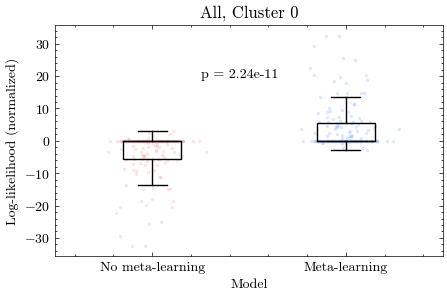

In [35]:
aic_backward_no_meta = -2*best_llh_all_backward_no_meta + 2*4
aic_backward_first6 = -2*best_llh_all_backward_first6 + 2*5
llh_mean = (best_llh_all_backward_no_meta + best_llh_all_backward_first6) / 2
condition = 'All'
plt.figure(figsize=(5,3))
inds = (meta_data['Cluster']==cluster) & (meta_data['Condition']=='V1-V1')
this_llh_mean = llh_mean[inds]
noise = np.random.normal(0, 0.1, np.sum(inds))
m1_fit_metric = (best_llh_all_backward_no_meta[inds] - this_llh_mean)
m2_fit_metric = (best_llh_all_backward_first6[inds] - this_llh_mean)
t_stat, p_value = stats.ttest_rel(m1_fit_metric, m2_fit_metric, alternative='less')
plt.plot(np.ones(np.sum(inds))+noise, m1_fit_metric, '.', mew=0, ms=5, color='lightcoral', alpha=0.2)
plt.plot(np.ones(np.sum(inds))*2+noise, m2_fit_metric, '.', mew=0, ms=5, color='cornflowerblue', alpha=0.2)
plt.boxplot([m1_fit_metric, m2_fit_metric], sym='', widths=0.3, patch_artist=True, boxprops=dict(facecolor='none', color='black'), whiskerprops=dict(color='black'), medianprops=dict(color='black'), capprops=dict(color='black'))
plt.text(1.25, max(max(m1_fit_metric), max(m2_fit_metric))-10, f'p = {p_value:.2e}', horizontalalignment='left', verticalalignment='top')
plt.xlim(0.5,2.5)
plt.xticks([1,2], ['No meta-learning', 'Meta-learning'])
plt.xlabel('Model')
plt.ylabel('Log-likelihood (normalized)')
plt.title(f'{condition}, Cluster {cluster}')
plt.show()

### All (first 6 blocks)

In [36]:
subject_inds = (meta_data['Cluster'] == cluster) & (meta_data['Condition'] == 'V1-V1')

if __name__ == "__main__":
    inputs = []
    inputs_2 = []
    for i in range(best_params_all_backward_first6[subject_inds].shape[0]):
        params = best_params_all_backward_no_meta[subject_inds][i,:]
        inputs.append((this_model, i, niters_sim, params, 'V1-V1', 'backward', False))
        params = best_params_all_backward_first6[subject_inds][i,:]
        inputs_2.append((this_model, i, niters_sim, params, 'V1-V1', 'backward', True))
        
    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs)

    data_sim_backward_no_meta = {}
    for _, this_data in results:
        data_sim_backward_no_meta = helpers.concatenate_data(this_data, data_sim_backward_no_meta)

    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs_2)

    data_sim_backward = {}
    for _, this_data in results:
        data_sim_backward = helpers.concatenate_data(this_data, data_sim_backward)

/home/exouser/Desktop/jingjing/learning_hierarchy/helpers.py:918: RuntimeWarning: Mean of empty slice
  mean_population_counter1 = np.hstack((mean_population_counter1_12, np.nanmean(data_counter1[:,:,start_trial:int(start_trial+trials_to_probe)],axis=2)))
/home/exouser/Desktop/jingjing/learning_hierarchy/helpers.py:919: RuntimeWarning: Mean of empty slice
  mean_population_counter2 = np.hstack((mean_population_counter2_12, np.nanmean(data_counter2[:,:,start_trial:int(start_trial+trials_to_probe)],axis=2)))


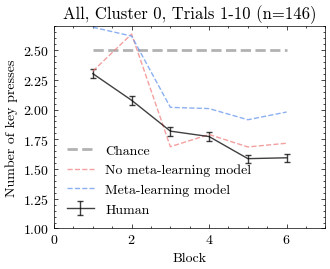

In [37]:
this_data = helpers.slice_data(all_data, meta_data, 'V1-V1', exp=[1,2], cluster=cluster)
plotting.plot_validation_n_presses(this_data, data_sim_backward_no_meta, data_sim_backward, 'All', cluster, nblocks=6, m1='No meta-learning', m2='Meta-learning')

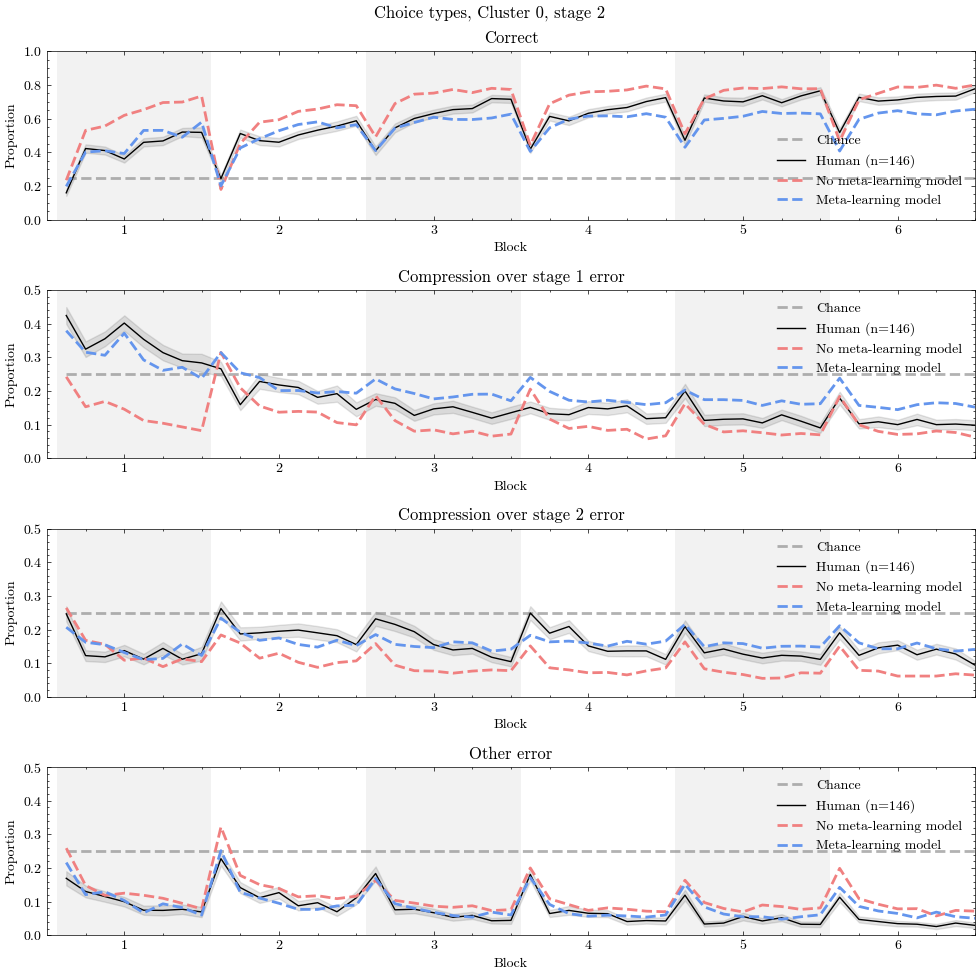

In [38]:
plotting.plot_validation_error_types(this_data, data_sim_backward_no_meta, data_sim_backward, 'All', cluster, nblocks=6, m1='No meta-learning', m2='Meta-learning', save_vector=True)

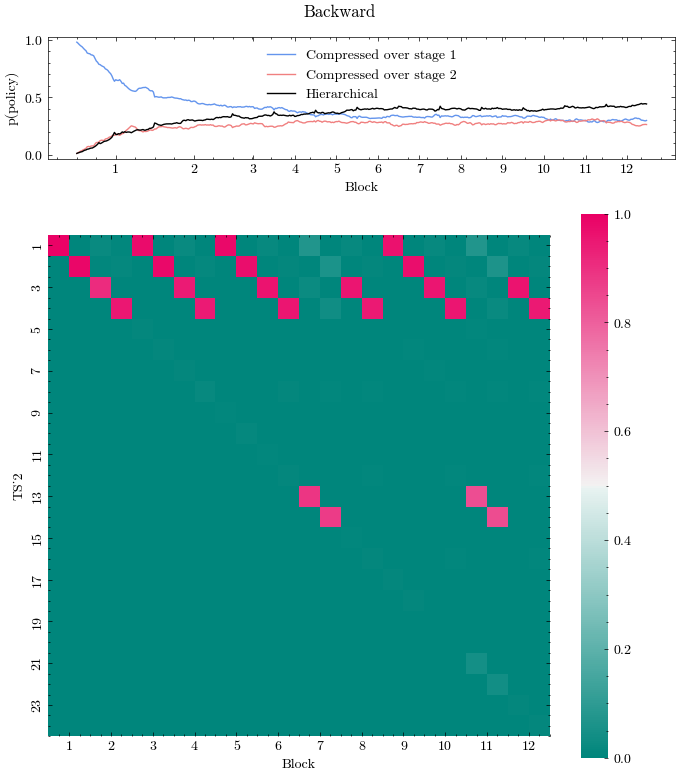

In [39]:
plotting.plot_validation_PTS(data_sim_backward, 'Backward', ntrials=5, cond='V1-V1', save_vector=True, pallette=None)

### Param recovery

In [40]:
this_model = 'option_model'
structure = 'backward'
meta_learning = True
cluster = 0
condition = 'All'
best_params_all_backward_first6 = np.load('fitting_results/backward_blocks1-6_params.npy')
fitted_params = best_params_all_backward_first6[(meta_data['Cluster']==cluster) & (meta_data['Condition']=='V1-V1')]
num_subject = fitted_params.shape[0]

best_llh_all = np.zeros(num_subject)
best_params_all = np.zeros((num_subject, len(param_names)))

all_sim_data = {}

if __name__ == "__main__":
    inputs = []
       
    for i in range(num_subject):
        inputs.append((this_model, i, 1, fitted_params[i], 'V1-V1', structure, meta_learning))
        
        
    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs)
        
    inputs = []
        
    for i, this_data in results:
        all_sim_data = helpers.concatenate_data(this_data, all_sim_data)
        D = helpers.get_model_fit_data(this_data, num_block=6)  
        inputs.append((this_model, D, structure, i, bounds, meta_learning))

    with Pool() as p:
        results = p.map(modeling.parallel_worker, inputs)

    for i, best_params, best_llh in results:
        best_params_all[i, :], best_llh_all[i] = best_params, best_llh

np.save(f'fitting_results/paramrec_{structure}_{condition}_cluster{cluster}_params.npy', best_params_all)
np.save(f'fitting_results/paramrec_{structure}_{condition}_cluster{cluster}_llh.npy', best_llh_all)

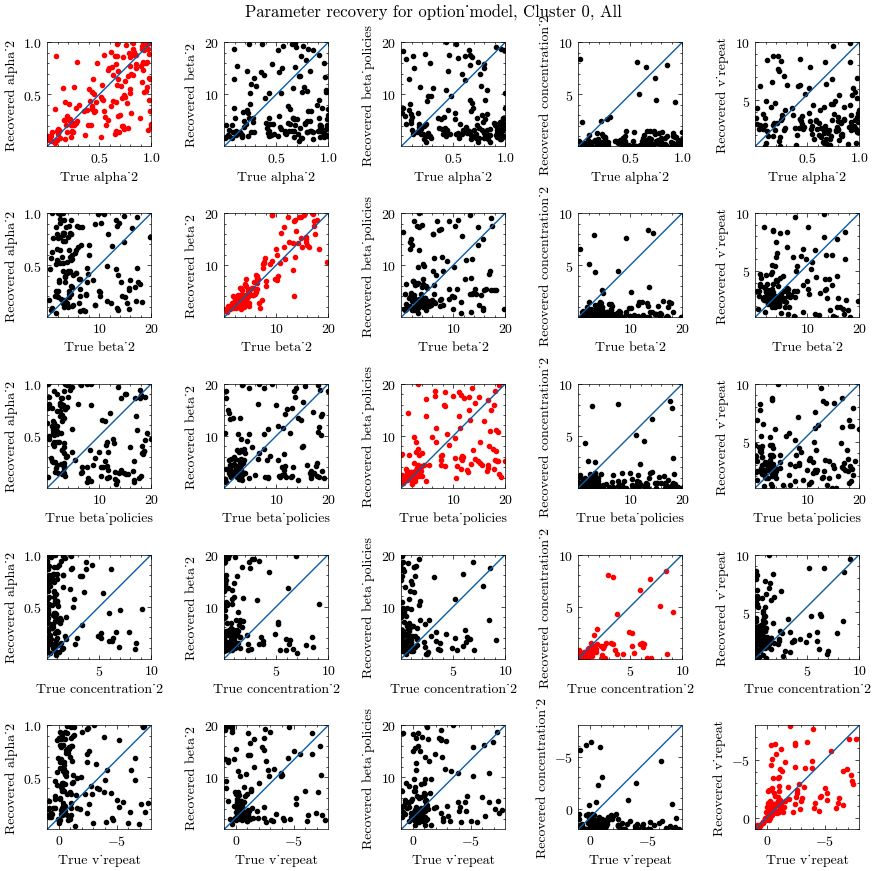

In [47]:
plt.figure(figsize=(9,9))
for p in range(len(bounds)):
    for q in range(len(bounds)):
        ax = plt.subplot(len(bounds), len(bounds), p*len(bounds)+q+1)
        p_bounds = bounds[p].copy()
        q_bounds = bounds[q].copy()

        values_p = fitted_params[:,p]
        values_q = best_params_all[:,q]
        mult = -1 if 'v_repeat' in param_names[p] else 1
        add = 2 if 'v_repeat' in param_names[p] else 0
        if 'concentration' in param_names[p] or 'v_repeat' in param_names[p]:
            p_bounds[0] = 10**p_bounds[0] * mult + add
            p_bounds[1] = 10**p_bounds[1] * mult + add
            values_p = 10**values_p * mult + add
        if 'concentration' in param_names[q] or 'v_repeat' in param_names[q]:
            q_bounds[0] = 10**q_bounds[0] * mult + add
            q_bounds[1] = 10**q_bounds[1] * mult + add
            values_q = 10**values_q * mult + add
        color = 'r' if p == q else 'k'
        plt.plot(values_p, values_q, '.', color=color)
        plt.plot([p_bounds[0],p_bounds[1]], [q_bounds[0], q_bounds[1]])
        plt.xlim(p_bounds)
        plt.ylim(q_bounds)
        plt.xlabel(f'True {param_names[p]}')
        plt.ylabel(f'Recovered {param_names[q]}')
        ax.set_box_aspect(1)

plt.suptitle(f'Parameter recovery for {this_model}, Cluster {cluster}, {condition}')
plt.tight_layout()
plt.show()

### Validation

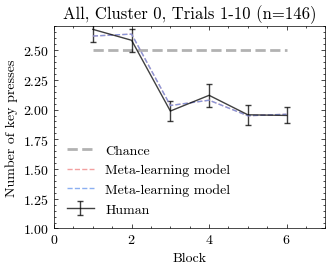

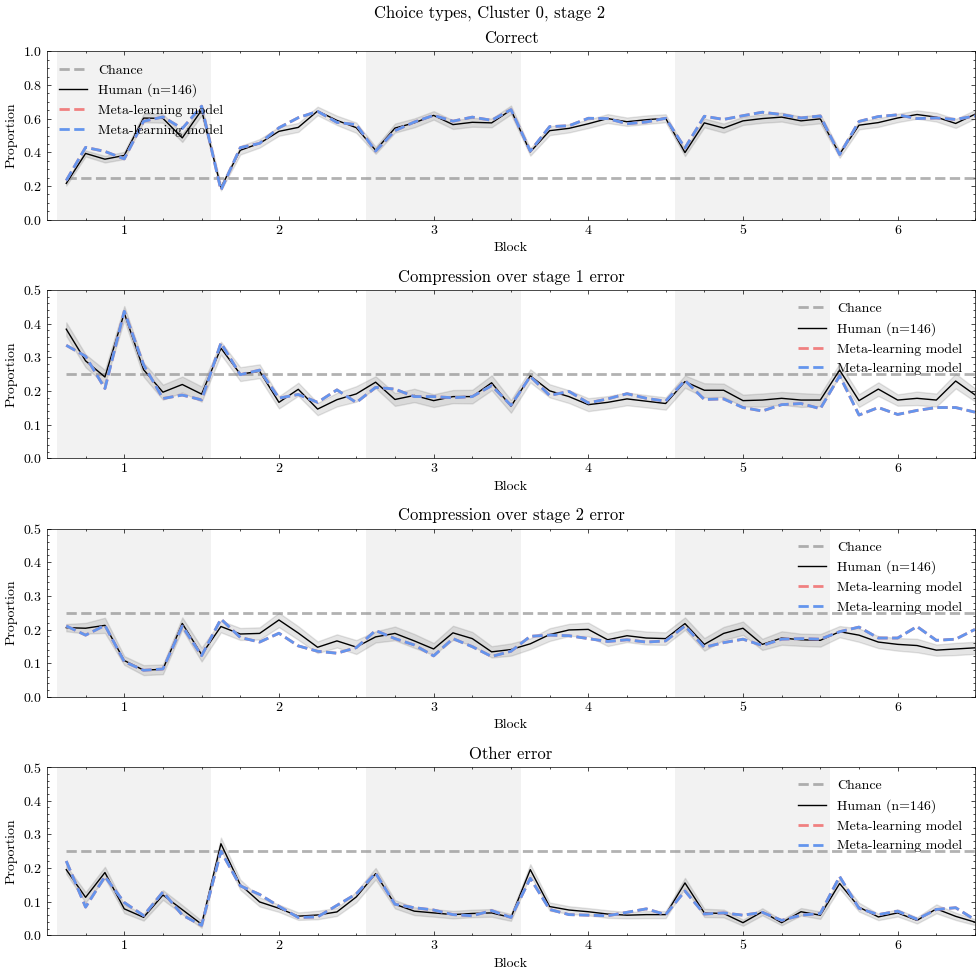

In [48]:
all_sim_data_rec = {}

if __name__ == "__main__":
    inputs = []
       
    for i in range(num_subject):
        inputs.append((this_model, i, 1, fitted_params[i], 'V1-V1', structure, meta_learning))
        
        
    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs)
        
    inputs = []
        
    for i, this_data in results:
        all_sim_data_rec = helpers.concatenate_data(this_data, all_sim_data_rec)
        
plotting.plot_validation_n_presses(all_sim_data, all_sim_data_rec, all_sim_data_rec, 'All', 0, nblocks=6, m1='Meta-learning', m2='Meta-learning')
plotting.plot_validation_error_types(all_sim_data, all_sim_data_rec, all_sim_data_rec, 'All', cluster, nblocks=6, m1='Meta-learning', m2='Meta-learning')

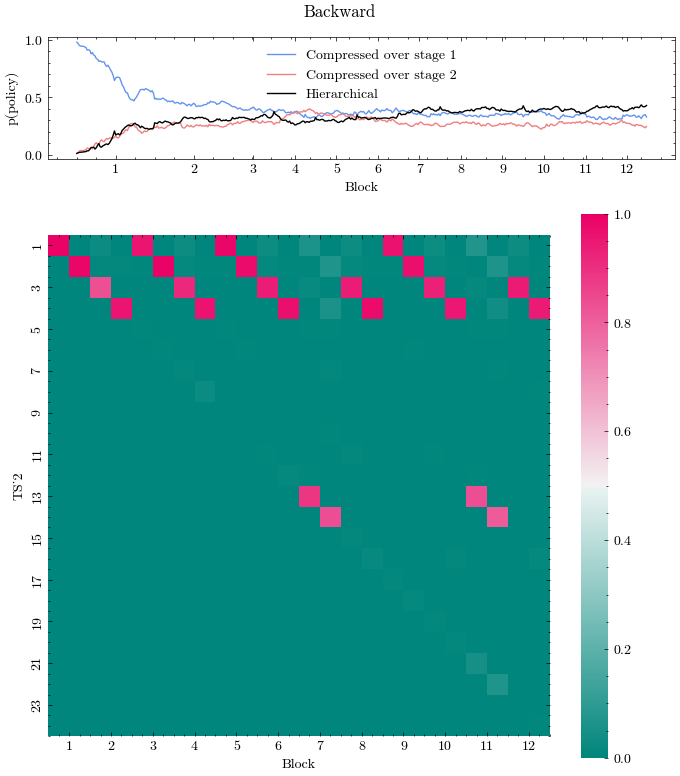

In [49]:
plotting.plot_validation_PTS(all_sim_data, 'Backward', ntrials=5, cond='V1-V1', save_vector=True, pallette=None)

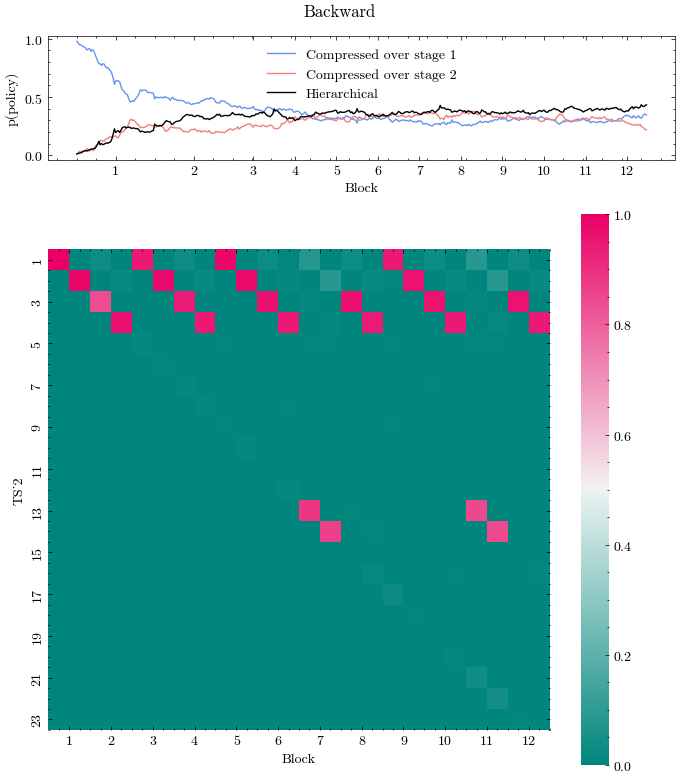

In [50]:
plotting.plot_validation_PTS(all_sim_data_rec, 'Backward', ntrials=5, cond='V1-V1', save_vector=True, pallette=None)